# Diversity summary
results were obtain by launching launch_eval_toxicity.sh for each setting

/var/folders/fy/__8z8cpn6gs04465sq9g1nq80000gn/T/ipykernel_55343/3203080713.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({"model": model, "special_token": special, "toxicity": data})])


file does not exist
file does not exist


/Users/leo/mambaforge/envs/skrub/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/leo/mambaforge/envs/skrub/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/leo/mambaforge/envs/skrub/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/leo/mambaforge/envs/skrub/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

<Axes: xlabel='toxicity', ylabel='Proportion'>

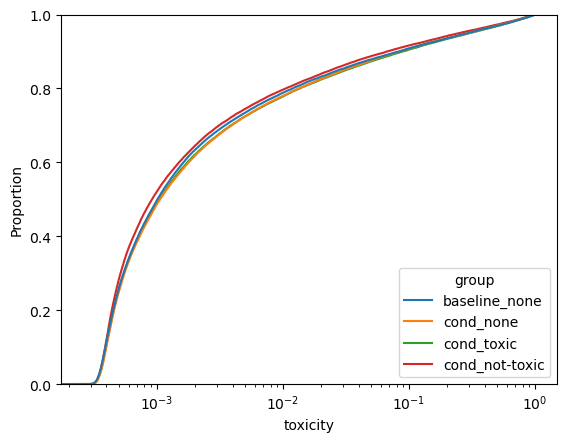

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
filename = "results/hails_{}-410m-20btoks_64000_64_{}_temp0.9.np"
models = ["baseline", "cond"]
special_token = ["none", "toxic", "not-toxic"]
# create the dataframe
df = pd.DataFrame(columns=["model", "special_token", "toxicity"])
for model in models:
    for special in special_token:
        if not os.path.exists(filename.format(model, special)):
            print("file does not exist")
            continue
        data = np.load(filename.format(model, special))
        df = pd.concat([df, pd.DataFrame({"model": model, "special_token": special, "toxicity": data})])


df["group"] = df["model"] + "_" + df["special_token"]
import seaborn as sns
# facet grid
# g = sns.FacetGrid(df, row="special_token", margin_titles=True, hue="model")
# g.map(sns.kdeplot, "toxicity", bw_adjust=.5, clip_on=False,
#       fill=True, alpha=0.5, linewidth=1.5)

# # log scale
# plt.xscale("log")

# ecdf plot
sns.ecdfplot(data=df, x="toxicity", hue="group", log_scale=True)


In [2]:
# show a table with the mean, std, media, and quantiles
df.groupby(["model", "special_token"]).describe()

toxicity                                          \
                          count      mean       std       min       25%   
model    special_token                                                    
baseline none           64000.0  0.043082  0.142311  0.000265  0.000493   
cond     none           64000.0  0.043262  0.141428  0.000265  0.000502   
         not-toxic      64000.0  0.039184  0.134222  0.000270  0.000475   
         toxic          64000.0  0.044281  0.142994  0.000280  0.000497   

                                                      
                             50%       75%       max  
model    special_token                                
baseline none           0.001015  0.006042  0.997981  
cond     none           0.001064  0.006733  0.996327  
         not-toxic      0.000919  0.005368  0.997505  
         toxic          0.001050  0.006842  0.996731

In [3]:
# check if significant difference between the models
from scipy.stats import ttest_ind
df_cond = df[df["model"] == "cond"]
for special in special_token:
    print("special token: {}".format(special))
    t, p = ttest_ind(df_cond[df_cond["special_token"] == special]["toxicity"],
                        df[df["special_token"] == "none"]["toxicity"])
    print("t: {}, p: {}".format(t, p))



special token: none
t: 0.13082532184690604, p: 0.8959136282783048
special token: toxic
t: 1.6106873647092796, p: 0.10724952489132186
special token: not-toxic
t: -5.910593498621669, p: 3.414500712143117e-09


In [4]:
# show the proportion for 0.01 for each model and special token
df[df["toxicity"] > 0.8].groupby(["model", "special_token"]).count()#/ df.groupby(["model", "special_token"]).count()

toxicity  group
model    special_token                 
baseline none                734    734
cond     none                723    723
         not-toxic           618    618
         toxic               713    713

# Cond models like to generate special tokens

In [5]:
tokenizer = AutoTokenizer.from_pretrained("hails/cond-410m-20btoks")
model = AutoModelForCausalLM.from_pretrained("hails/cond-410m-20btoks")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [43]:
input_text = 'I live in Italy. '
input_ids = tokenizer.encode(input_text, return_tensors='pt')
# get the probability distribution of the next token
next_token_logits = model(input_ids).logits[:, -1, :]
next_token_probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
# show top 5 tokens and associated probabilities
for token, prob in zip(tokenizer.convert_ids_to_tokens(next_token_logits[0].topk(10).indices), next_token_probs[0].topk(5).values):
    print(token, prob)

Ġ tensor(0.7542, grad_fn=<UnbindBackward0>)
<|val1|> tensor(0.1181, grad_fn=<UnbindBackward0>)
ĠI tensor(0.0181, grad_fn=<UnbindBackward0>)
Ċ tensor(0.0169, grad_fn=<UnbindBackward0>)
ĠThe tensor(0.0074, grad_fn=<UnbindBackward0>)


# General evaluation results
Run with lm-evaluation-harness

In [5]:
import pandas as pd

# Define the data in a tabular structure
data = {
    'Tasks': ['arc_challenge', 'arc_challenge', 'arc_easy', 'arc_easy', 'hellaswag', 'hellaswag', 'lambada_openai', 'lambada_openai', 
              'logiqa', 'logiqa', 'piqa', 'piqa', 'sciq', 'sciq', 'winogrande', 'wsc'],
    'Version': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    'Filter': ['none']*16,
    'n-shot': [0]*16,
    'Metric': ['acc', 'acc_norm', 'acc', 'acc_norm', 'acc', 'acc_norm', 'perplexity', 'acc', 'acc', 'acc_norm', 'acc', 'acc_norm', 'acc', 'acc_norm', 'acc', 'acc'],
    'Value': [0.1937, 0.2338, 0.4630, 0.4192, 0.2932, 0.3221, 26.0467, 0.3887, 0.2151, 0.2780, 0.6192, 0.6219, 0.7580, 0.6600, 0.5020, 0.3654],
    'Stderr': [0.0115, 0.0124, 0.0102, 0.0101, 0.0045, 0.0047, 0.9274, 0.0068, 0.0161, 0.0176, 0.0113, 0.0113, 0.0136, 0.0150, 0.0141, 0.0474]
}

# Create the DataFrame
df_original = pd.DataFrame(data)

# Add the model_name column with value "10K_original"
df_original['model_name'] = "10K_original"

# Display the DataFrame
df_original

,Tasks,Version,Filter,n-shot,Metric,Value,Stderr,model_name
0,arc_challenge,1,none,0,acc,0.1937,0.0115,10K_original
1,arc_challenge,1,none,0,acc_norm,0.2338,0.0124,10K_original
2,arc_easy,1,none,0,acc,0.4630,0.0102,10K_original
3,arc_easy,1,none,0,acc_norm,0.4192,0.0101,10K_original
4,hellaswag,1,none,0,acc,0.2932,0.0045,10K_original
5,hellaswag,1,none,0,acc_norm,0.3221,0.0047,10K_original
6,lambada_openai,1,none,0,perplexity,26.0467,0.9274,10K_original
7,lambada_openai,1,none,0,acc,0.3887,0.0068,10K_original
8,logiqa,1,none,0,acc,0.2151,0.0161,10K_original
9,logiqa,1,none,0,acc_norm,0.2780,0.0176,10K_original


In [6]:
import pandas as pd

# Define the data as a list of dictionaries
data = [
    {'Tasks': 'arc_challenge', 'Version': 1, 'Filter': 'none', 'n-shot': 0, 'Metric': 'acc', 'Value': 0.1860, 'Stderr': 0.0114},
    {'Tasks': 'arc_challenge', 'Version': 1, 'Filter': 'none', 'n-shot': 0, 'Metric': 'acc_norm', 'Value': 0.2184, 'Stderr': 0.0121},
    {'Tasks': 'arc_easy', 'Version': 1, 'Filter': 'none', 'n-shot': 0, 'Metric': 'acc', 'Value': 0.4078, 'Stderr': 0.0101},
    {'Tasks': 'arc_easy', 'Version': 1, 'Filter': 'none', 'n-shot': 0, 'Metric': 'acc_norm', 'Value': 0.3716, 'Stderr': 0.0099},
    {'Tasks': 'hellaswag', 'Version': 1, 'Filter': 'none', 'n-shot': 0, 'Metric': 'acc', 'Value': 0.2782, 'Stderr': 0.0045},
    {'Tasks': 'hellaswag', 'Version': 1, 'Filter': 'none', 'n-shot': 0, 'Metric': 'acc_norm', 'Value': 0.2925, 'Stderr': 0.0045},
    {'Tasks': 'lambada_openai', 'Version': 1, 'Filter': 'none', 'n-shot': 0, 'Metric': 'perplexity', 'Value': 68.3163, 'Stderr': 2.8080},
    {'Tasks': 'lambada_openai', 'Version': 1, 'Filter': 'none', 'n-shot': 0, 'Metric': 'acc', 'Value': 0.2800, 'Stderr': 0.0063},
    {'Tasks': 'logiqa', 'Version': 1, 'Filter': 'none', 'n-shot': 0, 'Metric': 'acc', 'Value': 0.2058, 'Stderr': 0.0159},
    {'Tasks': 'logiqa', 'Version': 1, 'Filter': 'none', 'n-shot': 0, 'Metric': 'acc_norm', 'Value': 0.2596, 'Stderr': 0.0172},
    {'Tasks': 'piqa', 'Version': 1, 'Filter': 'none', 'n-shot': 0, 'Metric': 'acc', 'Value': 0.6110, 'Stderr': 0.0114},
    {'Tasks': 'piqa', 'Version': 1, 'Filter': 'none', 'n-shot': 0, 'Metric': 'acc_norm', 'Value': 0.6017, 'Stderr': 0.0114},
    {'Tasks': 'sciq', 'Version': 1, 'Filter': 'none', 'n-shot': 0, 'Metric': 'acc', 'Value': 0.6960, 'Stderr': 0.0146},
    {'Tasks': 'sciq', 'Version': 1, 'Filter': 'none', 'n-shot': 0, 'Metric': 'acc_norm', 'Value': 0.6190, 'Stderr': 0.0154},
    {'Tasks': 'winogrande', 'Version': 1, 'Filter': 'none', 'n-shot': 0, 'Metric': 'acc', 'Value': 0.5130, 'Stderr': 0.0140},
    {'Tasks': 'wsc', 'Version': 1, 'Filter': 'none', 'n-shot': 0, 'Metric': 'acc', 'Value': 0.3654, 'Stderr': 0.0474}
]

# Create the DataFrame
df_baseline = pd.DataFrame(data)

# Add the model_name column with value "baseline"
df_baseline['model_name'] = "baseline"

# Display the DataFrame
df_baseline

,Tasks,Version,Filter,n-shot,Metric,Value,Stderr,model_name
0,arc_challenge,1,none,0,acc,0.1860,0.0114,baseline
1,arc_challenge,1,none,0,acc_norm,0.2184,0.0121,baseline
2,arc_easy,1,none,0,acc,0.4078,0.0101,baseline
3,arc_easy,1,none,0,acc_norm,0.3716,0.0099,baseline
4,hellaswag,1,none,0,acc,0.2782,0.0045,baseline
5,hellaswag,1,none,0,acc_norm,0.2925,0.0045,baseline
6,lambada_openai,1,none,0,perplexity,68.3163,2.8080,baseline
7,lambada_openai,1,none,0,acc,0.2800,0.0063,baseline
8,logiqa,1,none,0,acc,0.2058,0.0159,baseline
9,logiqa,1,none,0,acc_norm,0.2596,0.0172,baseline


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
df = pd.concat([df_original, df_baseline])
df['model_name'] = df['model_name'].astype('category')

fig = px.bar(df, x="Tasks", y="Value", color="model_name", barmode="group", error_y="Stderr", facet_col="Metric")
# Update the layout for a more customized and cleaner look
fig.update_layout(
    title="Performance of Models by Task, Metric, and Version",
    xaxis_title="Tasks",
    yaxis_title="Value",
    legend_title="Model Name",
    font=dict(family="Arial, sans-serif", size=12, color="RebeccaPurple"),
    template="plotly_white",
    margin=dict(l=20, r=20, t=60, b=20),  # Adjust the margins if needed
)

# Set each facet to have its own y-axis scale
fig.update_yaxes(matches=None)

# Improve the facet titles
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

# Show the figure
fig.show()

# save figure in good quality
#fig.write_image("fig1.png", scale=3)


/Users/leo/mambaforge/envs/skrub/lib/python3.10/site-packages/plotly/express/_core.py:1971: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(required_grouper, sort=False)  # skip one_group groupers


(I wouldn't trust the following results too much, it's only a few toxic datapoints for each model (also sometimes the api failed, I counted this as not-toxic))

In [8]:
import pandas as pd
import plotly.express as px

# Create a pandas DataFrame with your data
data = {
    "Tasks": [
        "realtoxicityprompts_not_toxic",
        "realtoxicityprompts_toxic",
        "realtoxicityprompts",
        "realtoxicityprompts"
    ],
    "Version": [0, 0, 0, 0],
    "Filter": ["none", "none", "none", "none"],
    "n-shot": [0, 0, 0, 0],
    "Metric": [
        "toxicity_perspective_api",
        "toxicity_perspective_api",
        "toxicity_perspective_api",
        "toxicity_perspective_api"
    ],
    "Value": [0.0022, 0.0056, 0.0046, 0.0026],
    "Stderr": [0.0007, 0.0011, 0.001, 0.0007],
    "Model": [
        "hails/cond-410m-20btoks",
        "hails/cond-410m-20btoks",
        "hails/cond-410m-20btoks",
        "hails/baseline-410m-20btoks"
    ]
}

df = pd.DataFrame(data)

# Define the order of the tasks
task_order = [
    "realtoxicityprompts_not_toxic",
    "realtoxicityprompts",
    "realtoxicityprompts_toxic"
]

# Sort the DataFrame based on the task order and model
df['Tasks'] = pd.Categorical(df['Tasks'], categories=task_order, ordered=True)
df.sort_values(['Tasks', 'Model'], ascending=[True, False], inplace=True)

# Plot using Plotly Express
fig = px.bar(df, x="Tasks", y="Value", color="Model", error_y="Stderr",
             title="Proportion of Toxic Completion as Measured by Perspective API on 5K examples",
             labels={"Value": "Proportion of toxic completions", "Tasks": "Tasks"},
             barmode='group')

# make if less wide and prettier
fig.update_layout(
    width=800,
    height=600,
    font=dict(family="Arial, sans-serif", size=12, color="RebeccaPurple"),
    template="plotly_white",
    margin=dict(l=20, r=20, t=60, b=20),  # Adjust the margins if needed
)

# Show the plot
fig.show()